# Cardano Mainnet Stake Distribution: Implications for Voting

This notebook is best viewed at https://nbviewer.org/.

## Set up

In [1]:
require(bit64)
require(data.table)
require(ggplot2)
require(magrittr)

## Query `cardano-db-sync`

```sql
select
    epoch_no                  as "Epoch"
  , encode(hash_raw, 'hex')   as "Pool"
  , sum(amount)               as "Stake [Lovelace]"
  , sum(amount) / total_stake as "Stake [Fraction]"
  from epoch_stake
  inner join pool_hash
    on epoch_stake.pool_id = pool_hash.id
  inner join (
    select epoch_no, sum(amount) as total_stake
      from epoch_stake
      group by epoch_no
  ) stake_total
    using (epoch_no)
  group by epoch_no, hash_raw, total_stake
;

\copy stake_distribution to 'stake_distribution.csv' csv header
```

In [2]:
stakeDistribution <- fread("http://ipfs.functionally.io/ipfs/QmbnnWaaKTQddiefiEUxruh2w2wa6eFn9FFb7y82wm3ubz")[order(`Epoch`, `Stake [Lovelace]`)][`Stake [Lovelace]` > 0]
stakeDistribution %>% summary

     Epoch           Pool           Stake [Lovelace]         
 Min.   :210.0   Length:820505      Min.   :             16  
 1st Qu.:308.0   Class :character   1st Qu.:     2488192396  
 Median :377.0   Mode  :character   Median :   154548144737  
 Mean   :376.6                      Mean   :  8594972171029  
 3rd Qu.:447.0                      3rd Qu.:  4577810115154  
 Max.   :518.0                      Max.   :486514766981074  
 Stake [Fraction]   
 Min.   :0.000e+00  
 1st Qu.:1.040e-07  
 Median :6.740e-06  
 Mean   :3.766e-04  
 3rd Qu.:1.983e-04  
 Max.   :3.107e-02  

In [3]:
stakeDistribution %>% tail

Epoch,Pool,Stake [Lovelace],Stake [Fraction]
<int>,<chr>,<int64>,<dbl>
518,fa58244068bef886049b3e8fbba8aa39f227ce78168efdf7629111c5,74157834756944,0.003313531
518,cdb10209d937fc1559c635e35b9147febde5307b4a7d276f868775cd,74232623503538,0.003316872
518,7b75bdba3b996dc88fdc00099d794d1460cf6bf7a5997a0da1197f4e,74424362424073,0.003325440
518,ad3d89ffc0e5347b94e61b8f61a672b5d2fa6d37e815fa3f217123a2,75856788916417,0.003389444
518,a10865dae2d543ee9f13e98bff70ea81565bb6e4343b15b765f78174,76646267577145,0.003424719
518,fcc675f8266022c4a0f8a7f1e24b00896fd742b35f147304c2354442,100529552205832,0.004491875


## Plot the stake distribution by epoch

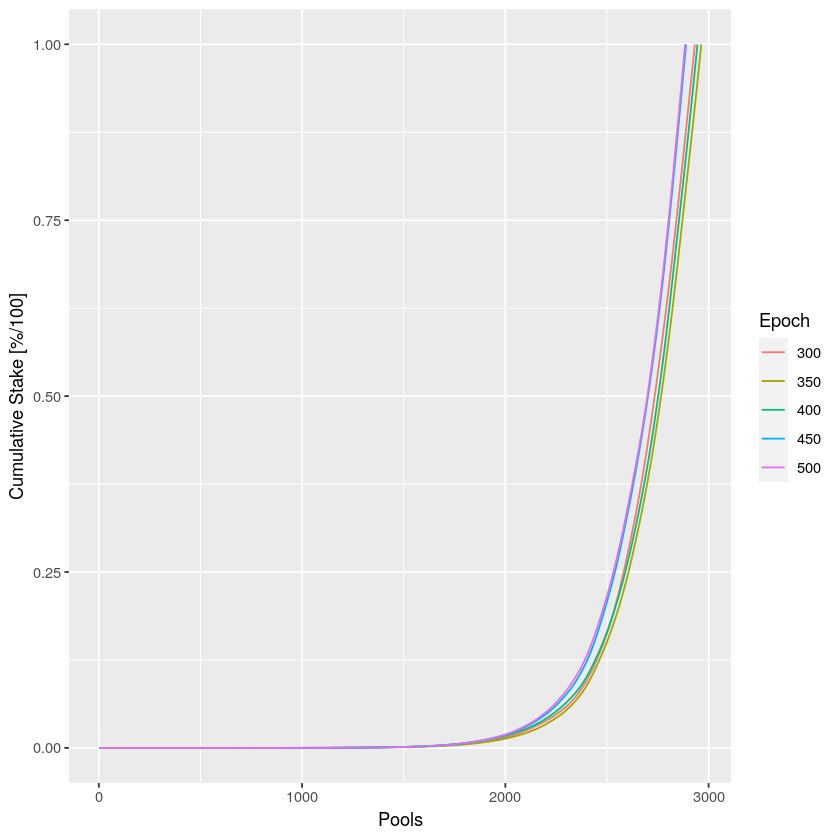

In [4]:
ggplot(
    stakeDistribution[
        `Epoch` %in% c(300,350,400,450,500),
        .(`Pools`=rank(.I), `Cumulative Stake [%/100]`=cumsum(`Stake [Fraction]`)),
        by=.(`Epoch`=factor(`Epoch`))
    ],
    aes(x=`Pools`, y=`Cumulative Stake [%/100]`, color=`Epoch`)
) +
  geom_line()

In [5]:
ggsave("stake_distribution.svg", width=8, height=6, units="in", dpi=200)

In [6]:
ggsave("stake_distribution.png", width=8, height=6, units="in", dpi=200)

## Number of unique nodes in voting committee

Let $p$ be the probability that a unit of stake (i.e., one lovelace in Cardano) will be selected in the voting lottery and let $S$ be the total staked. Let $n$ be the desired mean number of votes in the lottery. Hence $p = n / S$.

A candidate node $i$ with $s_i$ staked to it has a binomially distributed number of votes, with mean $p \cdot s_i$. The probability $v_i = 1 - \left( 1 - p \right)^{s_i}$ that the node has any votes at all.

We want to know how many distinct nodes vote in a given round. If the random variable $\mathbf{V}_i$ is distributed according to the Bernoulli trial with probability $v_i$, then $\mathbf{V} = \sum_i \mathbf{V}_i$ is the committee size. This will differ from the number of votes because some nodes might have multiple votes.

It's feasible to numerically sample $\mathbf{V}$, but simply computing its mean and standard deviation is insightful. The mean is $\mu = \sum_i v_i$ and the variance is $\sigma^2 = \sum_i v_i \cdot \left( 1 - v_i \right)$.

Below we estimate $\mu$ and $\mu \pm 2 \sigma$ for the empirical distribution of stake.

In [7]:
# Statistics for a mean committee size `n` and a stake distribution `stake`.
committee <- function(n, stakes) {
    p <- n / sum(stakes)
    v0 <- (1 - p)^as.numeric(stakes)
    v1 <- 1 - v0
    meanC <- sum(v1)
    sdC <- sum(v0 * v1) %>% sqrt
    list(`μ`=meanC, `μ-2σ`=meanC-2*sdC, `μ+2σ`=meanC+2*sdC)
}

In [8]:
voteplot <- function(n)
    
ggplot(
    melt(
        stakeDistribution[, committee(n, `Stake [Lovelace]`), by=.(`Epoch`)], 
        id.vars=c("Epoch"), 
        measure.vars=c("μ+2σ", "μ", "μ-2σ"),
        variable.name="Statistic",
        value.name="Number of Unique Nodes in Committee"
    ),
    aes(x=`Epoch`, y=`Number of Unique Nodes in Committee`, color=`Statistic`)
) +
    geom_line() +
    ggtitle(paste("Unique voters for", n, "votes"))

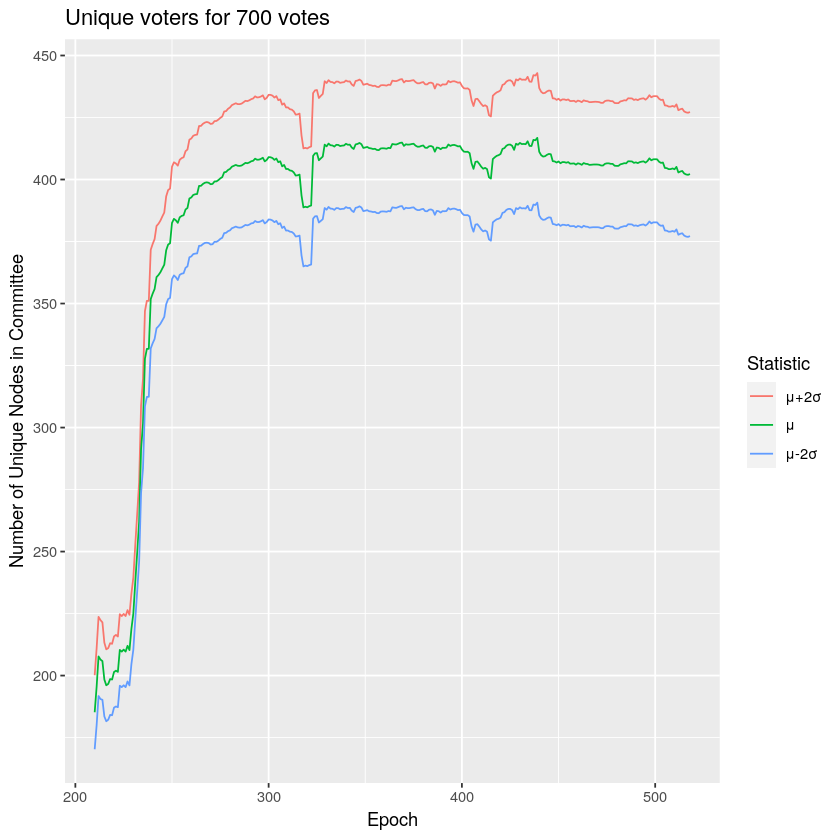

In [9]:
voteplot(700)

In [10]:
ggsave("committee_statistics-700.png", width=8, height=6, units="in", dpi=200)

In [11]:
ggsave("committee_statistics-700.svg", width=8, height=6, units="in", dpi=200)

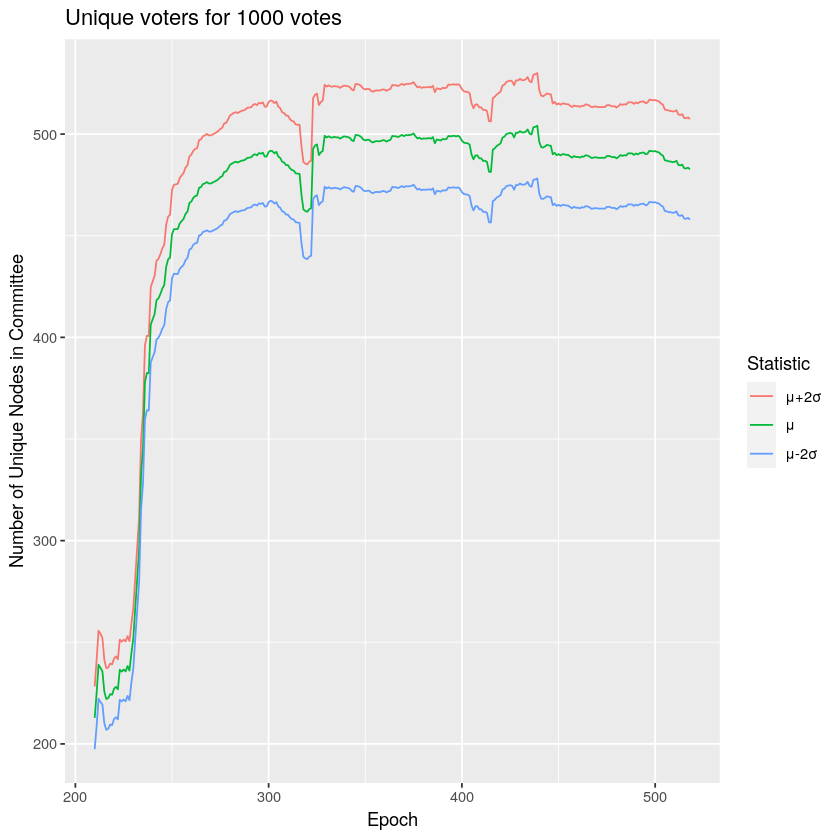

In [12]:
voteplot(1000)

In [13]:
ggsave("committee_statistics-1000.png", width=8, height=6, units="in", dpi=200)

In [14]:
ggsave("committee_statistics-1000.svg", width=8, height=6, units="in", dpi=200)

## Investigate the case of uniformly distributed stake

The worst-case scenario for number of unique nodes is when stake is uniformly distributed.

In [15]:
uniformStake <- 
    CJ(`Mean Number of Votes`=c(100,200,300,400,500,600,700,800,900,1000), `Number of Block Producers`=c(500,1000,1500,2000,2500,3000,3500,4000))[,
        committee(`Mean Number of Votes`, rep(stakeDistribution[`Epoch` == 500, sum(`Stake [Lovelace]`)] /  `Number of Block Producers`, `Number of Block Producers`)),
        by=.(`Mean Number of Votes`, `Number of Block Producers`)
    ]

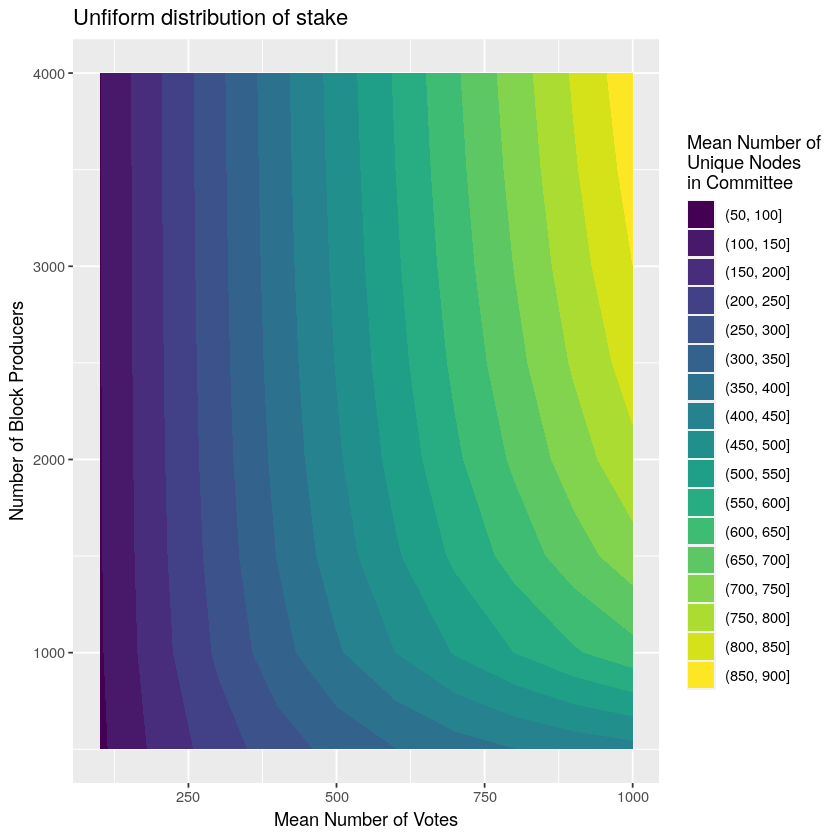

In [16]:
ggplot(uniformStake, aes(x=`Mean Number of Votes`, y=`Number of Block Producers`, z=`μ`)) +
  geom_contour_filled(binwidth=50) +
  guides(fill=guide_legend(title="Mean Number of\nUnique Nodes\nin Committee")) +
  ggtitle("Unfiform distribution of stake")

In [17]:
ggsave("uniform_statistics.png", width=8, height=6, units="in", dpi=200)

In [18]:
ggsave("uniform_statistics.svg", width=8, height=6, units="in", dpi=200)

## Number of unique votes in certificate

We'll employ a monte-carlo simulation to compute the distribution of the number of signed votes in a certificate.

First define a function to perform a Peras or Leios lottery.

In [19]:
sortition <- function(stakes, n_votes)
    sample(1:length(stakes), n_votes, replace=TRUE, prob=stakes/sum(stakes))

Now define a function to compute the number of items included in an ALBA certificate.

In [20]:
alba_u <- function(nf, np, l_sec)
  ceiling((l_sec + log(l_sec, 2) + 5 - log(log(exp(1), 2), 2)) / log(np/nf, 2))

ALBA selects signed votes according to multinomial distribution of vote weights.

In [21]:
alba_unique <- function(nf, np, l_sec, weights)
    sample(1:length(weights), alba_u(nf, np, l_sec), replace=TRUE, prob=weights/sum(weights)) %>% unique %>% length

We want to sample this multiple times.

In [22]:
alba_votes <- function(nf, np, l_sec, n_votes, stakes, n_samples)
    mapply(
        function(i) alba_unique(nf, np, l_sec, sortition(stakes, n_votes)),
        1:n_samples
    )

### Application to Peras

Because of the intersection argument Peras must have `nf >= 0.75`. Additionally, we choose `np =< 0.80` so that adversaries with less than 20% stake cannot disrupt voting. Given the strength of Peras's other security, an appropriate value for the security parameter is `l_sec = 80`. The Peras CIP recommends `n_votes = 900`.

In [23]:
n_votes <- 900
nf <- 0.75
np <- 0.80
l_sec <- 80
2 ^ -l_sec

[1] 8.271806e-25

In [24]:
alba_u(nf, np, l_sec)

[1] 976

In [25]:
perasCertVotes <- stakeDistribution[, .(`Unique votes included in certificate`=alba_votes(nf, np, l_sec, n_votes, `Stake [Fraction]`, 300)), by=.(`Epoch`)]

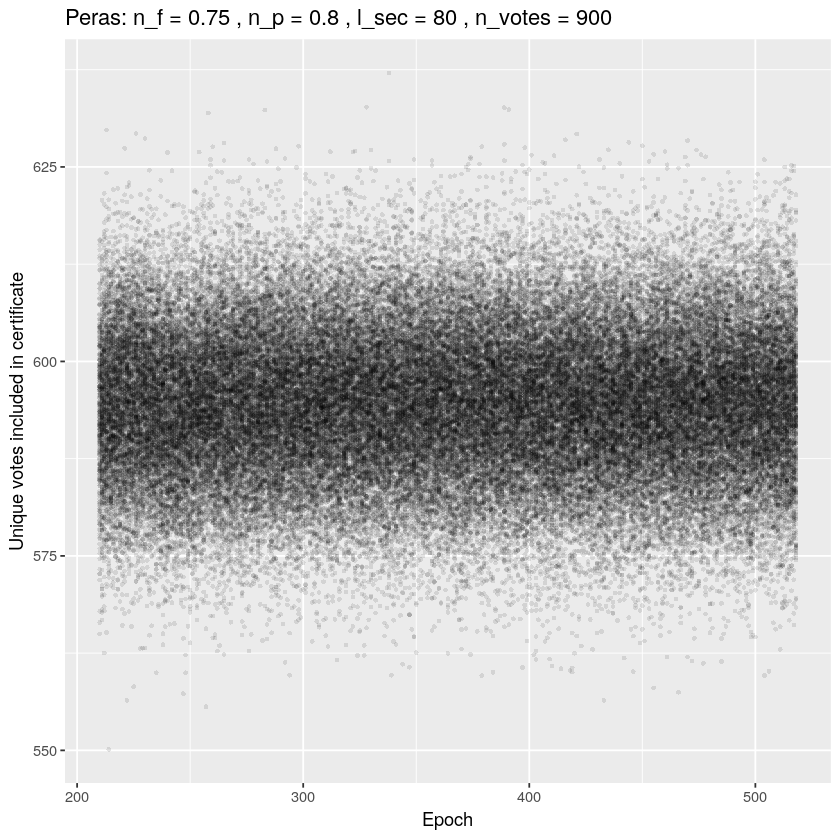

In [26]:
ggplot(
    perasCertVotes,
    aes(x=`Epoch`, y=`Unique votes included in certificate`)
) +
    geom_jitter(size=1, alpha=0.1, shape=16, width=0, height=0.5) +
    ggtitle(paste("Peras: n_f =", nf, ", n_p =", np, ", l_sec =", l_sec, ", n_votes =", n_votes))

In [27]:
ggsave("unique-votes-peras.png", width=8, height=6, units="in", dpi=200)

In [28]:
ggsave("unique-votes-peras.svg", width=8, height=6, units="in", dpi=200)

### Application to Leios

Leios needs to ensure the impossibility of an adversarial quorum, but it can accept adversarial activity causing quorum failures, since the latter just lowers throughput slightly.

We require a 60% quorum and 92% availability of honest votes, and set the committee size to 500 votes. Use the same security parameter as previously.

In [29]:
nf <- 0.60
np <- 0.92
l_sec <- 80
n_votes <- 500

Compute the probability of an adversarial quorum when the adversary has 35% of the stake. See <<https://peras.cardano-scaling.org/docs/reports/tech-report-2/#adversarial-quorum>>.

In [30]:
p_adversarial_quorum <- function(f_adversary, f_quorum, n_votes)
  pnorm(f_adversary, f_quorum, sqrt(f_adversary / n_votes))

In [31]:
p_adversarial_quorum(0.35, 0.60, 500)

[1] 1.708589e-21

See what happens is the adversary is stronger. We need external requirements to decide what would be acceptable!

In [32]:
p_adversarial_quorum(0.40, 0.60, 500)

[1] 7.687299e-13

In [33]:
p_adversarial_quorum(0.45, 0.60, 500)

[1] 2.866516e-07

In [34]:
p_adversarial_quorum(0.50, 0.60, 500)

[1] 0.0007827011

Compute the probability of an honest quorum when the adversary has 40% of the stake. See <<https://peras.cardano-scaling.org/docs/reports/tech-report-2/#no-honest-quorum-in-round>>.

In [35]:
p_no_honest_quorum <- function(f_adversary, f_quorum, n_votes)
  pnorm(f_adversary, 1 - f_quorum, sqrt((1 - f_adversary) / n_votes))

In [36]:
1 - p_no_honest_quorum(0.35, 0.60, 500)

[1] 0.9172411

Thus, there is a tiny chance of an adversarial quorum and the `np = 0.92` is consistent with the 91.7% chance of an honest quorum with a 35% adversary.

In [37]:
alba_u(nf, np, l_sec)

[1] 148

In [38]:
leiosCertVotes <- stakeDistribution[, .(`Unique votes included in certificate`=alba_votes(nf, np, l_sec, n_votes, `Stake [Fraction]`, 300)), by=.(`Epoch`)]

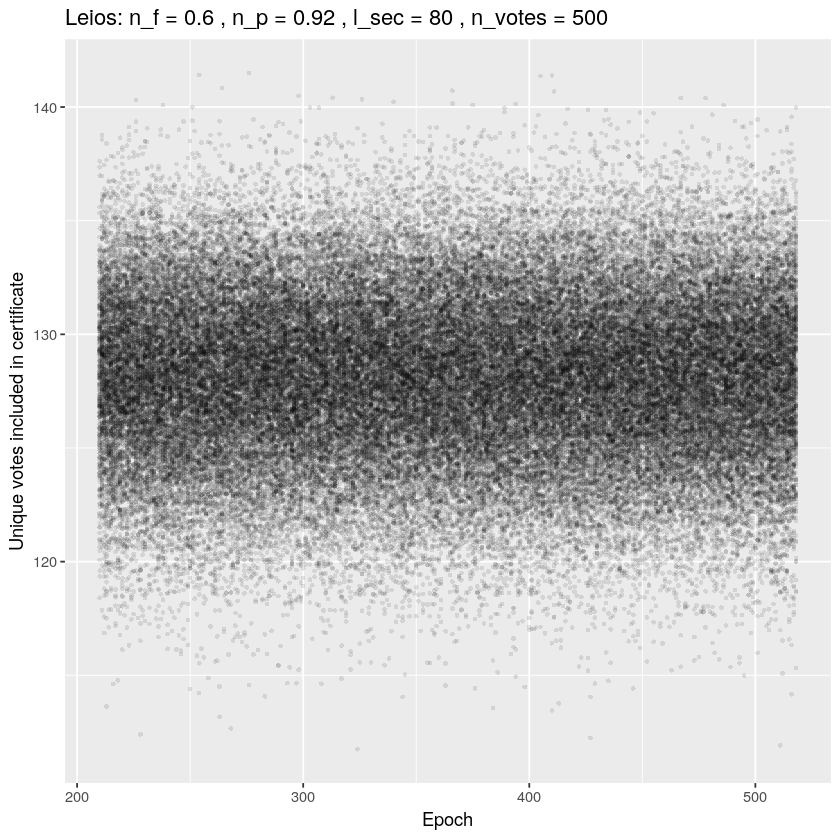

In [39]:
ggplot(
    leiosCertVotes,
    aes(x=`Epoch`, y=`Unique votes included in certificate`)
) +
    geom_jitter(size=1, alpha=0.1, shape=16, width=0, height=0.5) +
    ggtitle(paste("Leios: n_f =", nf, ", n_p =", np, ", l_sec =", l_sec, ", n_votes =", n_votes))

In [40]:
ggsave("unique-votes-leios.png", width=8, height=6, units="in", dpi=200)

In [41]:
ggsave("unique-votes-leios.svg", width=8, height=6, units="in", dpi=200)